# Bayesian Long Short-Term Memory Network Example

*Licensed under the Apache License, Version 2.0.*

This example implements a Bayesian version of LSTM (Hochreiter, Schmidhuber, 1997) using `tf.keras` and `edward2`.  
It's based on the discussion in this [issue](https://github.com/google/edward2/issues/474).  

In [20]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import edward2 as ed
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, ParameterGrid
from tensorflow.keras.preprocessing import sequence

import embedded_reber_grammar as erg

In [21]:
def plot_hist(hist):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.plot(hist.history['accuracy'], label='train_accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.plot(hist.history['loss'], label='train_loss')
    plt.legend()
    plt.show()

### Data generation
We generate random, valid and invalid strings from the embedded reber grammar as inputs. The objective is a binary classification between valid and invalid strings.

In [22]:
x, y = [], []
n = 3000
for i in range(n):
    x.append(np.asarray(erg.encode_string(erg.generate_valid_string(erg.embedded_rg))))
    y.append(1)
for i in range(n):
    x.append(np.asarray(erg.encode_string(erg.generate_invalid_string(erg.embedded_rg))))
    y.append(0)
x = sequence.pad_sequences(x)
x_train, x_test, y_train, y_test = train_test_split(np.asarray(x), np.asarray(y))

In [23]:
print(f"Number of training samples: {x_train.shape[0]}")
print(f"Number of test samples: {x_test.shape[0]} \n")

sequence_length = x_train.shape[1]
num_chars = x_train.shape[2]
print(f"Length of sequences: {sequence_length}")
print(f"Number of characters: {num_chars}")

Number of training samples: 4500
Number of test samples: 1500 

Length of sequences: 33
Number of characters: 8


#### Hyperparameters

In [24]:
batch_size = 64
epochs = 40

## Training a baseline LSTM
This is our baseline model. It's a simple RNN with a single layer of LSTM cells.  
As it would be expected the model can quickly be fitted to differentiate the valid from the invalid strings.

In [25]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, num_chars)))
model.add(tf.keras.layers.RNN(
    tf.keras.layers.LSTMCell(128)
))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_12 (RNN)                (None, 128)               70144     
                                                                 
 dense_24 (Dense)            (None, 32)                4128      
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 74,305
Trainable params: 74,305
Non-trainable params: 0
_________________________________________________________________


In [26]:
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0)

In [27]:
test_results = model.evaluate(x_test, y_test)
print(f"Test loss: {test_results[0]}")
print(f"Test accuracy: {test_results[1]}")

47/47 [==============================] - 0s 7ms/step - loss: 0.0810 - accuracy: 0.9800
Test loss: 0.08101668953895569
Test accuracy: 0.9800000190734863


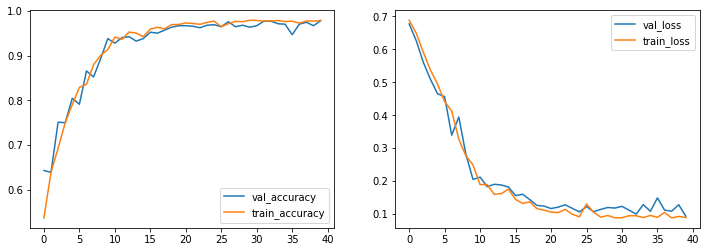

In [28]:
plot_hist(hist)

## Training a Bayesian LSTM
In comparison we build a similar RNN we we replace the standard LSTM cells with the LSTMCellFlipout class from `edward2`.

In [29]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, num_chars)))
model.add(tf.keras.layers.RNN(
    ed.layers.LSTMCellFlipout(128)
    ))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_13 (RNN)                (None, 128)               139776    
                                                                 
 dense_26 (Dense)            (None, 32)                4128      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 143,937
Trainable params: 143,937
Non-trainable params: 0
_________________________________________________________________


In [30]:
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=256, verbose=0)

From the training curves and the test results it's clear that the model is not converging and we are not able to differentiate the valid from the invalid strings.

In [31]:
test_results = model.evaluate(x_test, y_test)
print(f"Test loss: {test_results[0]}")
print(f"Test accuracy: {test_results[1]}")

47/47 [==============================] - 1s 11ms/step - loss: 135858.9844 - accuracy: 0.5007
Test loss: 135858.984375
Test accuracy: 0.5006666779518127


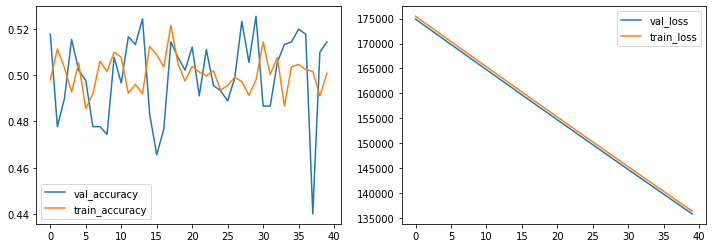

In [32]:
plot_hist(hist)

#### Hyperparameter tuning
In this section we run the experiments over a grid of, for BNN important, parameters.

In [33]:
params = {
    'loss_scaling': [1., 1./x_train.shape[0]],
    'batch_size': [64, 128, 256],
    'clipvalue': [None, 0.1, 0.5],
}

param_grid = ParameterGrid(params)
results = pd.DataFrame(columns=list(params.keys())+['test_loss', 'test_accuracy'])

In [34]:
def training_run(param_set):
    sf = param_set['loss_scaling']
    bs = int(param_set['batch_size'])
    cv = param_set['clipvalue']

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, num_chars)))
    model.add(tf.keras.layers.RNN(
        ed.layers.LSTMCellFlipout(
            128, 
            kernel_regularizer=ed.regularizers.NormalKLDivergence(scale_factor=sf),
            recurrent_regularizer=ed.regularizers.NormalKLDivergence(scale_factor=sf)
            ),
        ))
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(clipvalue=cv)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    hist = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=bs, verbose=0)
    return model, hist

In [35]:
for param_set in tqdm(param_grid):
    model, hist = training_run(param_set)

    test_results = np.mean(np.asarray([model.evaluate(x_test, y_test, verbose=0) for _ in range(10)]), axis=0)
    new_line = param_set
    new_line['test_loss'] = test_results[0]
    new_line['test_accuracy'] = test_results[1]
    results = pd.concat([results, pd.DataFrame(new_line, index=[0])], ignore_index=True, axis=0)

100%|██████████| 18/18 [22:06<00:00, 73.68s/it]


#### Analysing the impact of hyperparameters

The following plot shows the test accuracy over the hyperparameters. It's clear that scaling the loss of the Bayesian layers in the model is necessary to reach convergence.

To plot those results NaN values in the `clipvalues` column are set to `-1`. In the corresponding runs gradients were not clipped.

*What is the correct scaling factor for the regularizers?*

BNN use the Kullback-Leibler Divergence (KL-divergence) as a regularization term to minimize the difference between the prior distribution $p$ and the approximated posterior distribution $q$ over the parameters of the network. This divergence term is written as $KL(q||p)$.  

The KL-divergence should be included once for an entire dataset. Due to the implementation  in `tensorflow` the regularization term is added to the value of the loss function after every batch though, leading to a larger KL-divergence term compared to the loss. To bring both terms on the same scale, we apply a scaling factor < 1 to the KL-divergence. The loss for each batch is divided by the batch size and therefore $KL(q||p)$ (which is in relation to the complete dataset) is divided by the number of training samples (in this case `x_train.shape[0]`). 

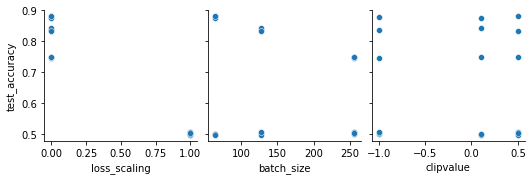

In [36]:
results_ = results.drop(columns=['test_loss']).fillna(-1)
sns.pairplot(results_, y_vars=['test_accuracy'], x_vars=['loss_scaling', 'batch_size', 'clipvalue'])

Choosing the correct batch size as well as possibly a value to clip gradients by during the training is more complicated.  
From those experiments it looks like a smaller batch size will be benefitial, even though this is also dependent on the dataset. Running this experiment with less samples shows that a larger batch size can greatly increase accuracy. A possible explaination for this behaviour is that in cases where less data is available, larger batch sizes compensate for the additional variance that is caused by the Bayesian properties.

Using this dataset, clipping the gradients doesn't seem to have a huge affect on the outcome although it is often an important technique with Bayesian LSTMs.

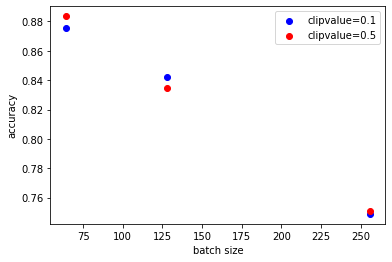

In [37]:
results_ = results_[results_['loss_scaling'] != 1.]
results_lowclip = results_[results_['clipvalue'] == 0.1].drop(columns=['loss_scaling'])
results_highclip = results_[results_['clipvalue'] == 0.5].drop(columns=['loss_scaling'])
plt.scatter(results_lowclip['batch_size'], results_lowclip['test_accuracy'], c='b', label="clipvalue=0.1")
plt.scatter(results_highclip['batch_size'], results_highclip['test_accuracy'], c='r', label="clipvalue=0.5")
plt.xlabel("batch size")
plt.ylabel("accuracy")
plt.legend()
plt.show()

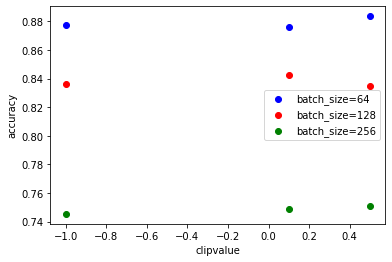

In [38]:
results_ = results_[results_['loss_scaling'] != 1.]
results_64 = results_[results_['batch_size'] == 64].drop(columns=['loss_scaling'])
results_128 = results_[results_['batch_size'] == 128].drop(columns=['loss_scaling'])
results_256 = results_[results_['batch_size'] == 256].drop(columns=['loss_scaling'])
plt.scatter(results_64['clipvalue'], results_64['test_accuracy'], c='b', label="batch_size=64")
plt.scatter(results_128['clipvalue'], results_128['test_accuracy'], c='r', label="batch_size=128")
plt.scatter(results_256['clipvalue'], results_256['test_accuracy'], c='g', label="batch_size=256")
plt.xlabel("clipvalue")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### Training the best Bayesian Model

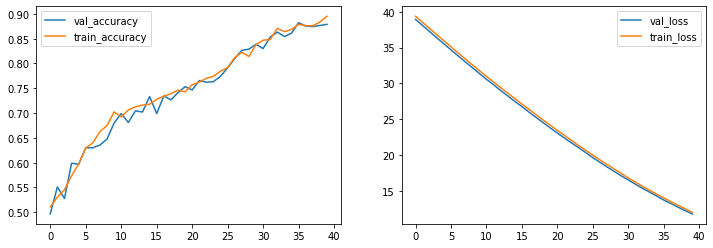

In [39]:
best_params = results_.iloc[np.argmax(results_['test_accuracy'])].to_dict()
if best_params['clipvalue'] < 0:
    best_params['clipvalue'] = None

model, hist = training_run(best_params)

plot_hist(hist)

### Conclusion
This example higlights a few pitfalls that can occur when working with BNNs and `edward2` for the first time. As seen from the results, especially scaling the loss values for any layers with Bayesian parameters is important to achieve convergence!  
Running the same experiments with a smaller dataset (e. g. 1500 samples in the training set), shows that the accuracy can improve if the batch size is increased. As this is not the case anymore for running the experiments with a larger dataset, this shows that choosing the correct batch size is important and that it differs from the "correct" batch size for the standard baseline model.
Gradient clipping can in many cases also be a helpfull technique to reach better results. Both batch size and gradient clipping are hyperparameters which need to be chosen carefully to achieve best results.